# Welcome to this tennis serving analysis!

My name is Jia Jie and I've always loved machine learning.

The following analysis is of ATP singles tennis match data taken from the years 2019-2023. It was originally a pre-interview task at a sports company and I enjoyed this so much that I felt I should share my findings with you. The star of the show is Novak Djokovic, selected arbitrarily, and we will be looking at how well he serves among other things.

I have split this into three parts. `Part I: Introduction` introduces the dataset, drawing some basic insights from it. We take a break from Djokovic in `Part II: Influence of Gender on Serving`, where we look at the sorts of differences in serving that arise from the biological differences between men and women. Finally, in `Part III: Ace-prediction model` we put into practice some key but simple supervised machine learning techniques to try to predict how many aces will happen in a particular match.

Hope you enjoy reading this as much as I did writing it. I've deliberately written this in a didactic way so as to (hopefully!) develop the skills of anybody with a basic knowledge of pandas, matplotlib and scikit-learn. If you're new like me, I'd also recommend undertaking a project like this as I learn a ton from the hands-on nature of this all.

Make sure you have pandas, scikit-learn, matplotlib, and seaborn installed before you begin!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

pd.set_option("display.max_columns", None)

In [109]:
df = pd.read_excel("tennis.xlsx")
df.head()

,X,tourney_id,tourney_name,surface,tourney_date,match_date,match_num,round,best_of,gender,winner_id,winner_seed,winner_rank,winner_name,winner_age,winner_rating_score,winner_serve_ability,loser_id,loser_seed,loser_rank,loser_name,loser_age,loser_rating_score,loser_serve_ability,score,minutes,winner_aces,winner_double_faults,winner_service_points,winner_first_serves_in,winner_first_serves_won,winner_second_serves_won,winner_break_points_saved,winner_break_points_faced,winner_sets,winner_games,loser_aces,loser_double_faults,loser_service_points,loser_first_serves_in,loser_first_serves_won,loser_second_serves_won,loser_break_points_saved,loser_break_points_faced,loser_sets,loser_games
0,1,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1123,R128,5,male,105173,NaN,48.0,Adrian Mannarino,30.9,712.4,755.2,105882,NaN,119.0,Stefano Travaglia,27.4,641.6,784.0,6-7(5) 6-3 3-6 6-2 6-2,224.0,5.0,2.0,170.0,105.0,72.0,33.0,8.0,12.0,3.0,27.0,13.0,3.0,147.0,77.0,55.0,33.0,4.0,12.0,2.0,20.0
1,2,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1153,R128,5,male,200282,21.0,25.0,Alex De Minaur,20.2,766.0,848.0,105614,NaN,89.0,Bradley Klahn,28.7,586.0,824.0,6-1 6-4 6-4,102.0,3.0,5.0,72.0,40.0,34.0,23.0,2.0,2.0,3.0,18.0,5.0,3.0,91.0,49.0,31.0,21.0,8.0,12.0,0.0,9.0
2,3,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1118,R128,5,male,122330,NaN,91.0,Alexander Bublik,21.9,644.8,775.6,200484,NaN,173.0,Rudolf Molleker,18.5,512.0,647.2,7-5 6-7(4) 6-1 7-6(2),154.0,30.0,9.0,133.0,77.0,63.0,31.0,5.0,8.0,3.0,26.0,12.0,11.0,167.0,100.0,62.0,33.0,12.0,18.0,1.0,19.0
3,4,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1116,R128,5,male,100644,5.0,5.0,Alexander Zverev,22.0,816.0,912.0,105357,NaN,56.0,John Millman,29.9,732.8,808.0,7-6(4) 6-3 2-6 6-7(5) 6-3,248.0,17.0,14.0,165.0,117.0,86.0,18.0,6.0,13.0,3.0,27.0,0.0,5.0,177.0,101.0,63.0,43.0,10.0,17.0,2.0,25.0
4,5,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1151,R128,5,male,200615,NaN,109.0,Alexei Popyrin,19.8,618.4,792.8,200005,NaN,61.0,Ugo Humbert,20.9,702.8,852.0,3-6 6-3 7-6(10) 6-3,172.0,12.0,6.0,132.0,83.0,68.0,23.0,7.0,9.0,3.0,22.0,7.0,4.0,122.0,75.0,52.0,33.0,7.0,10.0,1.0,18.0


## Part I: Introduction

Here we are simply exploring the dataframe a little. Our goal here is just to simply see what the dataset has to offer with some arbitrarily selected questions. I have selected Novak Djokovic as the main character of our analysis and we will start by answering some interesting questions about his play.

In [110]:
# Calculating the number of matches the winner and the loser has played
switched_df = df.rename(columns={"winner_id": "temp_id", "loser_id": "winner_id", "temp_id": "loser_id"})
concatenated_df = pd.concat([df, switched_df])
winner_matches_count = concatenated_df.groupby("winner_id").size().reset_index(name = "winner_matches_played")

# Merging onto the original dataframe
df_with_match_counts = pd.merge(df, winner_matches_count, on = "winner_id", how = "inner")

# Selecting (arbitrarily) the player with the most number of matches played
df_with_match_counts[df_with_match_counts["winner_matches_played"] == max(df_with_match_counts["winner_matches_played"])]

,X,tourney_id,tourney_name,surface,tourney_date,match_date,match_num,round,best_of,gender,winner_id,winner_seed,winner_rank,winner_name,winner_age,winner_rating_score,winner_serve_ability,loser_id,loser_seed,loser_rank,loser_name,loser_age,loser_rating_score,loser_serve_ability,score,minutes,winner_aces,winner_double_faults,winner_service_points,winner_first_serves_in,winner_first_serves_won,winner_second_serves_won,winner_break_points_saved,winner_break_points_faced,winner_sets,winner_games,loser_aces,loser_double_faults,loser_service_points,loser_first_serves_in,loser_first_serves_won,loser_second_serves_won,loser_break_points_saved,loser_break_points_faced,loser_sets,loser_games,winner_matches_played
46,47,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1101,R128,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,128034,NaN,44.0,Hubert Hurkacz,22.2,734.4,892.0,6-4 6-2 6-2,96.0,6.0,1.0,63.0,44.0,36.0,14.0,1.0,2.0,3.0,18.0,8.0,2.0,74.0,44.0,26.0,12.0,3.0,9.0,0.0,8.0,103
151,152,2019-520,Roland Garros,Clay,27/05/2019,28/05/2019,1201,R64,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,105967,NaN,104.0,Henri Laaksonen,27.1,604.0,685.2,6-1 6-4 6-3,93.0,4.0,2.0,66.0,44.0,36.0,12.0,0.0,1.0,3.0,18.0,6.0,1.0,82.0,50.0,32.0,13.0,4.0,10.0,0.0,8.0,103
203,204,2019-520,Roland Garros,Clay,27/05/2019,29/05/2019,1301,R32,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,106099,NaN,147.0,Salvatore Caruso,26.4,629.2,638.4,6-3 6-3 6-2,124.0,8.0,0.0,75.0,52.0,44.0,12.0,5.0,5.0,3.0,18.0,0.0,2.0,81.0,56.0,32.0,11.0,6.0,11.0,0.0,8.0,103
228,229,2019-520,Roland Garros,Clay,27/05/2019,30/05/2019,1401,R16,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,105526,NaN,45.0,Jan Lennard Struff,29.0,774.0,948.0,6-3 6-2 6-2,93.0,6.0,3.0,69.0,43.0,37.0,18.0,1.0,1.0,3.0,18.0,4.0,3.0,70.0,36.0,26.0,14.0,2.0,7.0,0.0,7.0,103
241,242,2019-520,Roland Garros,Clay,27/05/2019,31/05/2019,1501,QF,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,100644,5.0,5.0,Alexander Zverev,22.0,816.0,912.0,7-5 6-2 6-2,129.0,1.0,4.0,86.0,55.0,44.0,16.0,7.0,8.0,3.0,19.0,10.0,8.0,84.0,58.0,38.0,9.0,5.0,11.0,0.0,9.0,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,4523,2023-560,Us Open,Hard,28/08/2023,30/08/2023,211,R32,5,male,104925,2.0,2.0,Novak Djokovic,36.2,1044.0,1196.0,111513,32.0,38.0,Laslo Djere,28.2,718.0,864.0,4-6 4-6 6-1 6-1 6-3,225.0,12.0,4.0,127.0,83.0,64.0,24.0,8.0,11.0,3.0,26.0,8.0,2.0,143.0,100.0,66.0,18.0,7.0,14.0,2.0,17.0,103
4548,4549,2023-560,Us Open,Hard,28/08/2023,31/08/2023,219,R16,5,male,104925,2.0,2.0,Novak Djokovic,36.2,1044.0,1196.0,127339,NaN,105.0,Borna Gojo,25.4,682.8,940.0,6-2 7-5 6-4,146.0,12.0,3.0,76.0,51.0,45.0,13.0,0.0,1.0,3.0,19.0,14.0,8.0,114.0,73.0,48.0,16.0,8.0,13.0,0.0,11.0,103
4561,4562,2023-560,Us Open,Hard,28/08/2023,01/09/2023,223,QF,5,male,104925,2.0,2.0,Novak Djokovic,36.2,1044.0,1196.0,126203,9.0,9.0,Taylor Fritz,25.8,844.0,1040.0,6-1 6-4 6-4,155.0,7.0,5.0,94.0,57.0,39.0,21.0,10.0,12.0,3.0,18.0,8.0,2.0,89.0,49.0,36.0,11.0,3.0,9.0,0.0,9.0,103
4567,4568,2023-560,Us Open,Hard,28/08/2023,02/09/2023,225,SF,5,male,104925,2.0,2.0,Novak Djokovic,36.2,1044.0,1196.0,210097,NaN,47.0,Ben Shelton,20.8,737.6,952.0,6-3 6-2 7-6(4),161.0,5.0,3.0,99.0,67.0,56.0,11.0,4.0,6.0,3.0,19.0,5.0,5.0,102.0,72.0,43.0,14.0,9.0,14.0,0.0,11.0,103


### *What is Djokovic's win/loss record?*

In [111]:
djokovic_wins = df[df["winner_name"] == "Novak Djokovic"]
djokovic_losses = df[df["loser_name"] == "Novak Djokovic"]

total_games = len(djokovic_wins.index) + len(djokovic_losses.index)

print(f"Novak Djokovic has {len(djokovic_wins.index)} wins and {len(djokovic_losses.index)} losses")
print(f"His win percentage is {round((len(djokovic_wins.index)/total_games) * 100, 2)}%")

Novak Djokovic has 96 wins and 7 losses
His win percentage is 93.2%


Djokovic has 96 wins and 7 losses, putting him at a 93.2% win-rate. Impressive!

### *Which surface is best for Djokovic, and why?*

C:\Users\JiaJieHuang\AppData\Local\Temp\ipykernel_17452\2617389165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  djokovic_wins["win_or_loss"] = "win"
C:\Users\JiaJieHuang\AppData\Local\Temp\ipykernel_17452\2617389165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  djokovic_losses["win_or_loss"] = "loss"


,X,tourney_id,tourney_name,surface,tourney_date,match_date,match_num,round,best_of,gender,winner_id,winner_seed,winner_rank,winner_name,winner_age,winner_rating_score,winner_serve_ability,loser_id,loser_seed,loser_rank,loser_name,loser_age,loser_rating_score,loser_serve_ability,score,minutes,winner_aces,winner_double_faults,winner_service_points,winner_first_serves_in,winner_first_serves_won,winner_second_serves_won,winner_break_points_saved,winner_break_points_faced,winner_sets,winner_games,loser_aces,loser_double_faults,loser_service_points,loser_first_serves_in,loser_first_serves_won,loser_second_serves_won,loser_break_points_saved,loser_break_points_faced,loser_sets,loser_games,win_or_loss
46,47,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1101,R128,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,128034,NaN,44.0,Hubert Hurkacz,22.2,734.4,892.0,6-4 6-2 6-2,96.0,6.0,1.0,63.0,44.0,36.0,14.0,1.0,2.0,3.0,18.0,8.0,2.0,74.0,44.0,26.0,12.0,3.0,9.0,0.0,8.0,win
151,152,2019-520,Roland Garros,Clay,27/05/2019,28/05/2019,1201,R64,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,105967,NaN,104.0,Henri Laaksonen,27.1,604.0,685.2,6-1 6-4 6-3,93.0,4.0,2.0,66.0,44.0,36.0,12.0,0.0,1.0,3.0,18.0,6.0,1.0,82.0,50.0,32.0,13.0,4.0,10.0,0.0,8.0,win
203,204,2019-520,Roland Garros,Clay,27/05/2019,29/05/2019,1301,R32,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,106099,NaN,147.0,Salvatore Caruso,26.4,629.2,638.4,6-3 6-3 6-2,124.0,8.0,0.0,75.0,52.0,44.0,12.0,5.0,5.0,3.0,18.0,0.0,2.0,81.0,56.0,32.0,11.0,6.0,11.0,0.0,8.0,win
228,229,2019-520,Roland Garros,Clay,27/05/2019,30/05/2019,1401,R16,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,105526,NaN,45.0,Jan Lennard Struff,29.0,774.0,948.0,6-3 6-2 6-2,93.0,6.0,3.0,69.0,43.0,37.0,18.0,1.0,1.0,3.0,18.0,4.0,3.0,70.0,36.0,26.0,14.0,2.0,7.0,0.0,7.0,win
241,242,2019-520,Roland Garros,Clay,27/05/2019,31/05/2019,1501,QF,5,male,104925,1.0,1.0,Novak Djokovic,32.0,1036.0,1152.0,100644,5.0,5.0,Alexander Zverev,22.0,816.0,912.0,7-5 6-2 6-2,129.0,1.0,4.0,86.0,55.0,44.0,16.0,7.0,8.0,3.0,19.0,10.0,8.0,84.0,58.0,38.0,9.0,5.0,11.0,0.0,9.0,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,1248,2020-560,Us Open,Hard,31/08/2020,03/09/2020,212,R16,5,male,105807,20.0,27.0,Pablo Carreno Busta,29.1,NaN,NaN,104925,1.0,1.0,Novak Djokovic,33.2,NaN,NaN,6-5 DEF,60.0,3.0,0.0,36.0,24.0,18.0,6.0,4.0,4.0,1.0,6.0,9.0,0.0,28.0,20.0,16.0,5.0,1.0,2.0,0.0,5.0,loss
1522,1523,2020-520,Roland Garros,Clay,28/09/2020,04/10/2020,1701,F,5,male,104745,1.0,2.0,Rafael Nadal,34.3,1004.0,1128.0,104925,2.0,1.0,Novak Djokovic,33.3,1032.0,1136.0,6-0 6-2 7-5,161.0,4.0,1.0,84.0,55.0,37.0,19.0,4.0,5.0,3.0,19.0,1.0,4.0,99.0,66.0,33.0,16.0,11.0,18.0,0.0,7.0,loss
2538,2539,2021-560,Us Open,Hard,30/08/2021,05/09/2021,226,F,5,male,106421,2.0,2.0,Daniil Medvedev,25.5,980.0,1076.0,104925,1.0,1.0,Novak Djokovic,34.2,1040.0,1152.0,6-4 6-4 6-4,136.0,16.0,9.0,90.0,52.0,42.0,22.0,5.0,6.0,3.0,18.0,6.0,3.0,92.0,50.0,40.0,17.0,4.0,8.0,0.0,12.0,loss
3037,3038,2022-520,Roland Garros,Clay,23/05/2022,27/05/2022,220,QF,5,male,104745,5.0,5.0,Rafael Nadal,35.9,916.0,988.0,104925,1.0,1.0,Novak Djokovic,35.0,1036.0,1168.0,6-2 4-6 6-2 7-6(4),252.0,3.0,4.0,138.0,99.0,64.0,24.0,8.0,12.0,3.0,23.0,5.0,4.0,140.0,97.0,62.0,18.0,10.0,17.0,1.0,16.0,loss


win_or_loss,win,loss,win_percentage
surface,,,
Grass,27,1,96.428571
Hard,40,3,93.023256
Clay,29,3,90.625000


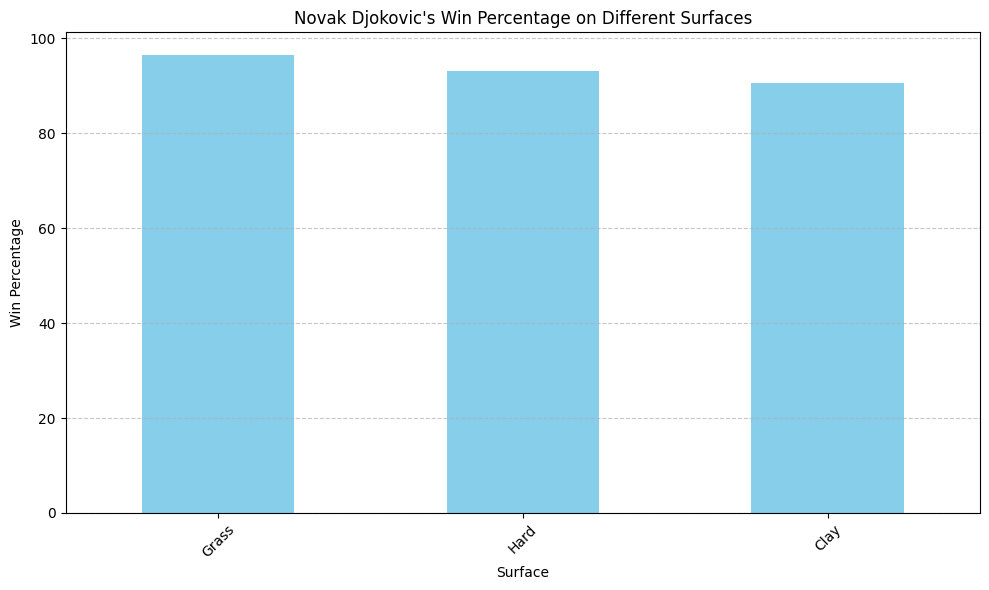

In [112]:
djokovic_wins["win_or_loss"] = "win"
djokovic_losses["win_or_loss"] = "loss"

djokovic_games = pd.concat([djokovic_wins, djokovic_losses])
display(djokovic_games)

# Group matches by surface and count wins and losses on each surface
surface_stats = djokovic_games.groupby("surface")["win_or_loss"].value_counts().unstack(fill_value=0)
surface_stats["win_percentage"] = surface_stats["win"] / (surface_stats["win"] + surface_stats["loss"]) * 100
surface_stats = surface_stats.sort_values(by="win_percentage", ascending=False)

display(surface_stats[["win", "loss", "win_percentage"]])

plt.figure(figsize=(10, 6))
surface_stats["win_percentage"].plot(kind="bar", color="skyblue")
plt.title("Novak Djokovic's Win Percentage on Different Surfaces")
plt.xlabel("Surface")
plt.ylabel("Win Percentage")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

A surface level analysis (excuse the pun) seems to reveal that Djokovic performs best on grass. However, we must exercise caution before jumping to such conclusions. As we know, correlation is not the same as causation. For example, courts that contain grass might correlate quite strongly with other factors that affect Djokovic's performance (e.g. country, date of the tournament). Additionally, the lack of losses in Djokovic's case mean that the percentage error associated with these measurements is very high, perhaps within the interval on which these win percentages lie (which is very small too - within 7%). Performance on different surfaces might also change with the number of years played as the player matures in their playstyle so as well as being potentially quite imprecise.

### *How well does Djokovic serve when under pressure?*

Firstly, what defines "under pressure"? This is a key question to ask ourselves when tackling this problem. This could refer to a variety of things:
- Strong opponent (by rating or by rank)
- Close match scores
- Longer game

We also need to ensure we have a good definition of "serving well". Some factors are:
- Number of aces
- Number of serves in
- Number of opponent breaks

In the subsequent analysis, although one could spend a long time (and should, if optimising for accuracy) we will only tackle the issue of **how well Djokovic serves against strong opponents by rating**. This provides a decent introduction as statistically speaking, games against higher rated players are also more likely to be close in score and longer.

In [113]:
# First finding the high-rated players, assuming that a 1000+ rated player has won at least one game

high_rated = list(df[df["winner_rating_score"] > 1000]["winner_name"].unique())
high_rated.remove("Novak Djokovic")

print(high_rated)

['Rafael Nadal', 'Roger Federer', 'Iga Swiatek']


Iga Swiatek is a woman (currently ranked as world number 1 in women's singles), so will not appear in the following analysis as men and women compete in separate tournaments in tennis.

In [114]:
serving_data = djokovic_games.loc[:, [
    "winner_name",
    "loser_name",
    "winner_serve_ability",
    "loser_serve_ability",
    "winner_aces",
    "loser_aces",
    "winner_break_points_saved",
    "loser_break_points_saved"
]]
serving_data["opponent"] = serving_data.apply(lambda row: row["loser_name"] if row["winner_name"] == "Novak Djokovic" else row["winner_name"], axis = 1)
serving_data["djokovic_serve_ability"] = serving_data.apply(lambda row: row["winner_serve_ability"] if row["winner_name"] == "Novak Djokovic" else row["loser_serve_ability"], axis = 1)
serving_data["djokovic_aces"] = serving_data.apply(lambda row: row["winner_aces"] if row["winner_name"] == "Novak Djokovic" else row["loser_aces"], axis = 1)
serving_data["opponent_break_points_saved"] = serving_data.apply(lambda row: row["loser_break_points_saved"] if row["winner_name"] == "Novak Djokovic" else row["winner_break_points_saved"], axis = 1)

# display(serving_data)

djokovic_serving_data = serving_data.loc[:, [
    "opponent",
    "djokovic_serve_ability",
    "djokovic_aces",
    "opponent_break_points_saved"
]]
djokovic_serving_data_vs_strong = djokovic_serving_data[djokovic_serving_data["opponent"].isin(high_rated)]

mean_djokovic_statistics = pd.DataFrame()
mean_djokovic_statistics["strong_opponents"] = djokovic_serving_data_vs_strong.mean(numeric_only = True)
mean_djokovic_statistics["all_opponents"] = djokovic_serving_data.mean(numeric_only = True)

display(mean_djokovic_statistics)

,strong_opponents,all_opponents
djokovic_serve_ability,1152.8,1164.120000
djokovic_aces,6.6,8.621359
opponent_break_points_saved,7.6,6.184466


As we can see, Djokovic's serving ability and capacity to score an ace is lower against stronger opponents. That should not come as too much of a surprise; higher-rated players are far better defenders and will punish Djokovic for mistakes that others won't. After all, we are talking about opponents of the likes of Nadal and Federer - who are arguably the two greatest of all time.

However, what caught my attention is the statistic that opponents of Djokovic appear to perform worse against him during break points. In my opinion, this is a decent representation of "being under pressure". I immediately checked to see if the games were all best of 5, which they were. Can one make the case that Djokovic serves well under pressure based off of that? Maybe. But again, our sample size for losses is unfortunately rather low and this leaves our data susceptible to large errors. Furthermore, there are so few players that are above 1000 rating points that individual psychology would come into play here and it could be the case that Federer and Nadal do not handle pressure poorly during break points for example. I doubt it personally, but we have to account for all possibilities as scientists and this is one of many ways that different factors can complicate the pictures.

Further ways to improve this analysis would be to do it for other players and see if there is a similar trend or if Djokovic is an exception. We might also plot a serve ability vs rating graph and see if there is a relationship between the two. The aforementioned surprising result could also be due to the games being longer, so perhaps it would have been wise to also include Djokovic's number of break points saved. But I have spent enough time on this.

## Part II: Influence of Gender on Serving
Here we will take a brief look at how the sex of a particular player affects their serve. We will illustrate these differences through Matplotlib visualisations.

### *What are the differences between data from men and women?*

The following is a surface-level analysis. I have taken the mean of all of the key statistics that I deem to be the most important components to serving well.

In [115]:
male_games = df[df["gender"] == "male"]
female_games = df[df["gender"] == "female"]

male_serving_data = male_games.loc[:, [
    "winner_name",
    "loser_name",
    "best_of",
    "winner_serve_ability",
    "loser_serve_ability",
    "winner_first_serves_in",
    "loser_first_serves_in",
    "winner_aces",
    "loser_aces",
    "winner_break_points_saved",
    "loser_break_points_saved"
]]
female_serving_data = female_games.loc[:, [
    "winner_name",
    "loser_name",
    "best_of",
    "winner_serve_ability",
    "loser_serve_ability",
    "winner_first_serves_in",
    "loser_first_serves_in",
    "winner_aces",
    "loser_aces",
    "winner_break_points_saved",
    "loser_break_points_saved"
]]

mean_serving_statistics = pd.DataFrame()
mean_serving_statistics["male"] = male_serving_data.mean(numeric_only = True)
mean_serving_statistics["female"] = female_serving_data.mean(numeric_only = True)
mean_serving_statistics["female_corrected"] = mean_serving_statistics.apply(
    lambda row: row * 5 / 3 if row.name not in ["winner_serve_ability", "loser_serve_ability"] else row,
    axis = 1
)["female"]

display(mean_serving_statistics)

print(f"Number of male games: {len(male_serving_data)}")
print(f"Number of female games: {len(female_serving_data)}")
print(f"Total male BO5s: {len(male_serving_data[male_serving_data['best_of'] == 5])}")
print(f"Total female BO3s: {len(female_serving_data[female_serving_data['best_of'] == 3])}")

,male,female,female_corrected
best_of,5.000000,3.000000,5.000000
winner_serve_ability,895.128014,782.451944,782.451944
loser_serve_ability,797.583231,691.006703,691.006703
winner_first_serves_in,70.312527,43.766491,72.944151
loser_first_serves_in,71.869890,44.405013,74.008355
winner_aces,9.902857,3.428320,5.713867
loser_aces,7.485714,2.135884,3.559807
winner_break_points_saved,4.800879,3.861917,6.436529
loser_break_points_saved,6.832527,4.883465,8.139109


Number of male games: 2286
Number of female games: 2286
Total male BO5s: 2286
Total female BO3s: 2286


The table represents the average of each of the listed columns on the left-hand side for men and women. All women's matches are best of 3 but all mens' matches are best of 5, so a correction factor of 5/3 has been applied to all of the female statistics, apart from the serve ability which has been assumed to be approximately invariant with respect to number of sets.

There are a few factors here to note (comparing the corrected female column and the male column):

#### The serving ability of men is noticeably higher on average
This is likely due to biological differences between men and women that allow for stronger, faster, and subsequently deadlier serves. This manifests especially in the number of aces; men almost double the number of aces that women get on average, even after correcting for best of 3, as well as the winner_serve_ability and loser_serve_ability.

#### The accuracy of the serves is approximately equal between men and women.
Perhaps unsurprising. Biological differences negligibly affect the number of first serves landing in. If anything, women are slightly better but the difference is marginal and maybe even within the percentage error.

#### Women defend break points far more frequently
This could be due to the slower pace of such games, in which strength is less of a factor and placement/tactical awareness becomes essential.

### *What does this look like graphically?*

For simplicity sake, we shall assume that all of the top 10 servers of each sex have won at least one game in the dataset.

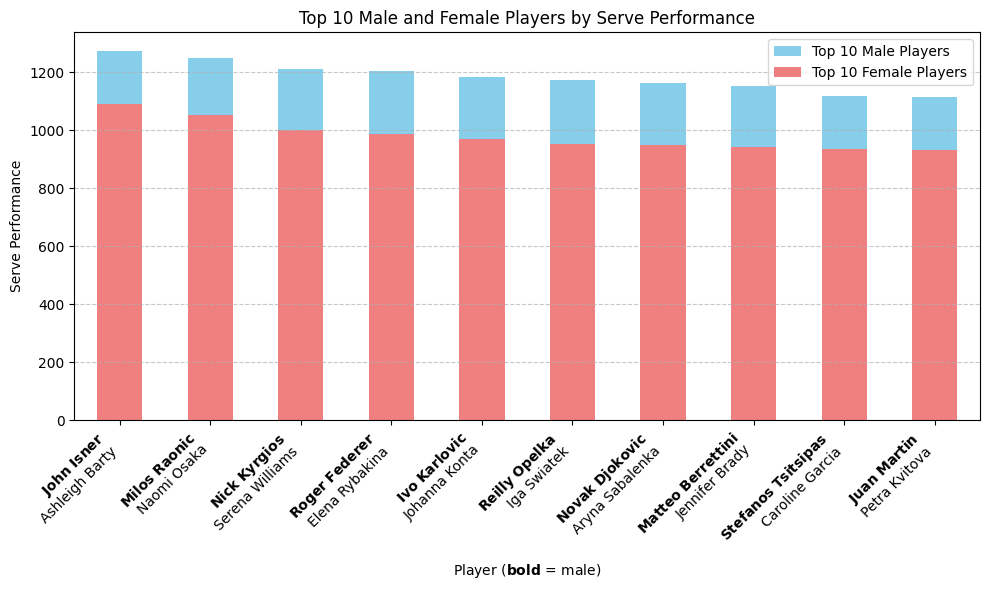

In [116]:
male_serve_performance = male_serving_data.groupby("winner_name")["winner_serve_ability"].mean()
top_10_male_players = male_serve_performance.nlargest(10)

female_serve_performance = female_serving_data.groupby("winner_name")["winner_serve_ability"].mean()
top_10_female_players = female_serve_performance.nlargest(10)

# Bar chart: Serve performance

fig, ax = plt.subplots(figsize=(10, 6))
top_10_male_players.plot(kind="bar", color="skyblue", ax=ax, label="Top 10 Male Players")
top_10_female_players.plot(kind="bar", color="lightcoral", ax=ax, label="Top 10 Female Players")

ax.set_title("Top 10 Male and Female Players by Serve Performance")
ax.set_xlabel("Player ($\mathbf{{bold}}$ = male)")
ax.set_ylabel("Serve Performance")

combined_players = zip(top_10_male_players.index.tolist(), top_10_female_players.index.tolist())
ax.set_xticklabels([f"$\mathbf{{{male.split()[0]}}}$ $\mathbf{{{male.split()[1]}}}$\n{female}" for (male, female) in combined_players], rotation=45, ha="right") # Painful syntax, apologies.
ax.grid(axis="y", linestyle="--", alpha=0.7)


ax.legend()

plt.tight_layout()
plt.show()

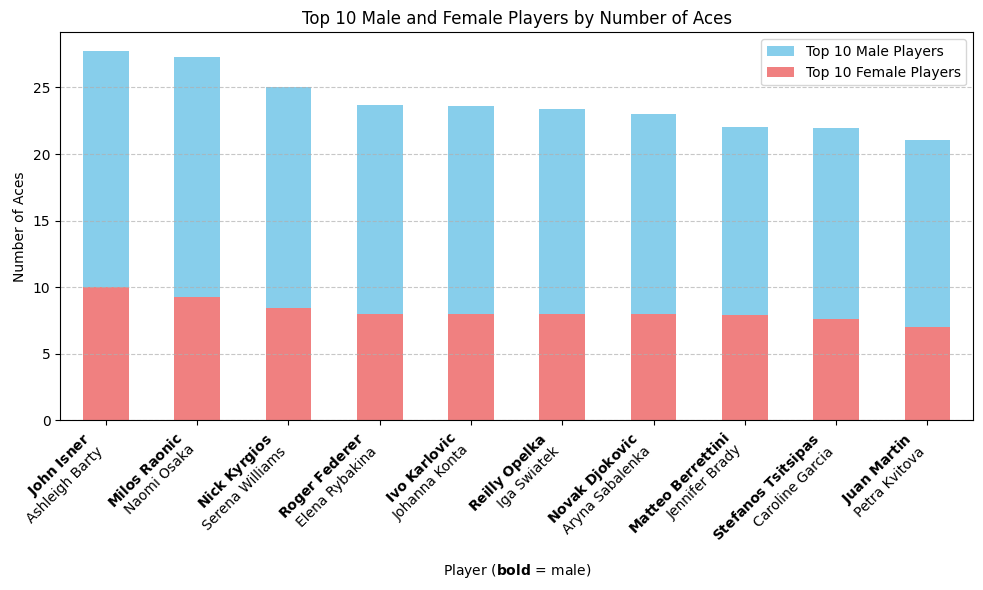

In [117]:
male_aces = male_serving_data.groupby("winner_name")["winner_aces"].mean()
top_10_male_players_aces = male_aces.nlargest(10)

female_aces = female_serving_data.groupby("winner_name")["winner_aces"].mean()
top_10_female_players_aces = female_aces.nlargest(10)

# Bar chart: Aces

fig, ax = plt.subplots(figsize=(10, 6))
top_10_male_players_aces.plot(kind="bar", color="skyblue", ax=ax, label="Top 10 Male Players")
top_10_female_players_aces.plot(kind="bar", color="lightcoral", ax=ax, label="Top 10 Female Players")

ax.set_title("Top 10 Male and Female Players by Number of Aces")
ax.set_xlabel("Player ($\mathbf{{bold}}$ = male)")
ax.set_ylabel("Number of Aces")

combined_players = [f"$\mathbf{{{male.split()[0]}}}$ $\mathbf{{{male.split()[1]}}}$\n{female}" for (male, female) in zip(top_10_male_players.index, top_10_female_players.index)]

ax.set_xticklabels(combined_players, rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.legend()

plt.tight_layout()
plt.show()

## Part III: Ace-prediction model

*Model that predicts the number of aces in a given match*

This is pretty much a textbook supervised machine learning model. Our label is the number of aces, and we need to do some feature selection to determine the most important factors to our model. We will go with a simple approach, in which we only pick a select few features.

### Pre-processing

Educated first guess as to possible features. Then refinement based on correlation with label.

,ohe__gender_female,ohe__gender_male,scale__winner_serve_ability,scale__winner_rating_score,scale__loser_serve_ability,scale__loser_rating_score,remainder__winner_rank,remainder__winner_age,remainder__loser_rank,remainder__loser_age,remainder__minutes,remainder__winner_sets,remainder__winner_games,remainder__loser_sets,remainder__loser_games,total_aces
ohe__gender_female,1.000000,-1.000000,-0.356274,-0.167503,-0.359269,-0.126369,0.032705,-0.117189,0.014439,-0.108139,-0.594283,-0.997758,-0.817014,-0.318294,-0.557395,0.001615
ohe__gender_male,-1.000000,1.000000,0.356274,0.167503,0.359269,0.126369,-0.032705,0.117189,-0.014439,0.108139,0.594283,0.997758,0.817014,0.318294,0.557395,-0.001615
scale__winner_serve_ability,-0.356274,0.356274,1.000000,0.845499,0.263567,0.246761,-0.473195,0.083166,-0.081693,0.016790,0.111109,0.356274,0.237707,-0.008913,0.086847,-0.027135
scale__winner_rating_score,-0.167503,0.167503,0.845499,1.000000,0.223843,0.269250,-0.577397,0.058598,-0.106469,-0.009198,-0.021314,0.167503,0.051185,-0.102526,-0.086889,-0.022755
scale__loser_serve_ability,-0.359269,0.359269,0.263567,0.223843,1.000000,0.807056,-0.087477,0.045596,-0.376759,0.022774,0.375592,0.359269,0.391097,0.249682,0.386729,-0.014105
scale__loser_rating_score,-0.126369,0.126369,0.246761,0.269250,0.807056,1.000000,-0.126899,0.010459,-0.503639,-0.044728,0.270548,0.126369,0.193416,0.192107,0.248409,0.000210
remainder__winner_rank,0.032705,-0.032705,-0.473195,-0.577397,-0.087477,-0.126899,1.000000,-0.012233,0.040113,0.014258,0.066088,-0.027059,0.026919,0.080505,0.088200,-0.006147
remainder__winner_age,-0.117189,0.117189,0.083166,0.058598,0.045596,0.010459,-0.012233,1.000000,0.000643,0.034723,0.067859,0.118234,0.088141,0.011732,0.037788,-0.011834
remainder__loser_rank,0.014439,-0.014439,-0.081693,-0.106469,-0.376759,-0.503639,0.040113,0.000643,1.000000,-0.026302,-0.081074,-0.015127,-0.051900,-0.078528,-0.089610,0.006902
remainder__loser_age,-0.108139,0.108139,0.016790,-0.009198,0.022774,-0.044728,0.014258,0.034723,-0.026302,1.000000,0.034919,0.102344,0.065099,0.012081,0.042770,0.005480


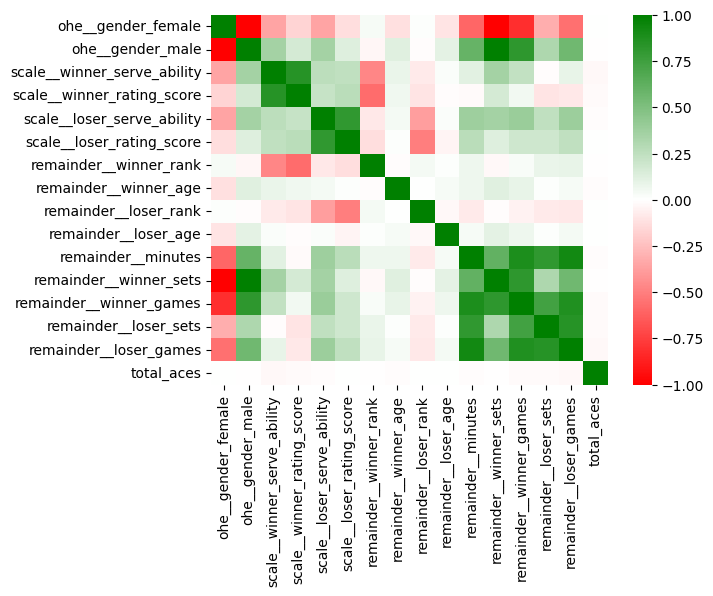

In [118]:
# Key candidate features picked out

raw_aces_data = df.loc[:, [
    "gender",
    "winner_rank",
    "winner_serve_ability",
    "winner_rating_score",
    "winner_age",
    "loser_rank",
    "loser_serve_ability",
    "loser_rating_score",
    "loser_age",
    "minutes",
    "winner_sets",
    "winner_games",
    "loser_sets",
    "loser_games"
]]

X = raw_aces_data.copy()
X["total_aces"] = df["winner_aces"] + df["loser_aces"]

y = X.pop("total_aces")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

# Future-proofing: making a column transformer

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(), ["gender"]),
        ("scale", StandardScaler(), ["winner_serve_ability", "winner_rating_score", "loser_serve_ability", "loser_rating_score"])
    ],
    remainder = "passthrough"
)

column_transformer.fit(raw_aces_data)

raw_aces_transformed = column_transformer.transform(raw_aces_data)
raw_aces_transformed = pd.DataFrame(raw_aces_transformed, columns = column_transformer.get_feature_names_out())

Xt_train = pd.DataFrame(column_transformer.transform(X_train), columns = column_transformer.get_feature_names_out())
Xt_test = pd.DataFrame(column_transformer.transform(X_test), columns=column_transformer.get_feature_names_out())

Xt_train_with_aces = Xt_train.copy()
Xt_train_with_aces["total_aces"] = y_train

display(Xt_train_with_aces.corr())

sns.heatmap(data = Xt_train_with_aces.corr(), cmap = LinearSegmentedColormap.from_list("rg",["r", "w", "g"], N=256))

plt.show()

Clearly, none of the selected features significantly correlate to the label `total_aces`. Let's see if any of the features in the entire dataset correlate whatsoever in a linear sense. Do any of them? I repeat the same code below, but with the all of the features instead of only a select few.

,ohe__gender_female,ohe__gender_male,scale__winner_serve_ability,scale__winner_rating_score,scale__loser_serve_ability,scale__loser_rating_score,remainder__X,remainder__match_num,remainder__best_of,remainder__winner_id,remainder__winner_seed,remainder__winner_rank,remainder__winner_age,remainder__loser_id,remainder__loser_seed,remainder__loser_rank,remainder__loser_age,remainder__minutes,remainder__winner_aces,remainder__winner_double_faults,remainder__winner_service_points,remainder__winner_first_serves_in,remainder__winner_first_serves_won,remainder__winner_second_serves_won,remainder__winner_break_points_saved,remainder__winner_break_points_faced,remainder__winner_sets,remainder__winner_games,remainder__loser_aces,remainder__loser_double_faults,remainder__loser_service_points,remainder__loser_first_serves_in,remainder__loser_first_serves_won,remainder__loser_second_serves_won,remainder__loser_break_points_saved,remainder__loser_break_points_faced,remainder__loser_sets,remainder__loser_games,total_aces
ohe__gender_female,1.000000,-1.000000,-0.356274,-0.167503,-0.359269,-0.126369,0.023543,0.111830,-1.000000,0.848252,0.104878,0.032705,-0.117189,0.852648,-0.026519,0.014439,-0.108139,-0.594283,-0.519589,-0.107312,-0.589014,-0.573297,-0.671092,-0.585391,-0.137716,-0.099042,-0.997758,-0.817014,-0.477409,-0.126446,-0.630313,-0.590267,-0.617627,-0.562063,-0.278789,-0.280647,-0.318294,-0.557395,0.001615
ohe__gender_male,-1.000000,1.000000,0.356274,0.167503,0.359269,0.126369,-0.023543,-0.111830,1.000000,-0.848252,-0.104878,-0.032705,0.117189,-0.852648,0.026519,-0.014439,0.108139,0.594283,0.519589,0.107312,0.589014,0.573297,0.671092,0.585391,0.137716,0.099042,0.997758,0.817014,0.477409,0.126446,0.630313,0.590267,0.617627,0.562063,0.278789,0.280647,0.318294,0.557395,-0.001615
scale__winner_serve_ability,-0.356274,0.356274,1.000000,0.845499,0.263567,0.246761,0.011935,-0.045954,0.356274,-0.340875,-0.530120,-0.473195,0.083166,-0.305319,-0.105237,-0.081693,0.016790,0.111109,0.441398,-0.041635,0.075752,0.063324,0.192648,0.149511,-0.123023,-0.198212,0.356274,0.237707,0.138000,-0.031331,0.131501,0.125686,0.162938,0.149884,0.022366,-0.036689,-0.008913,0.086847,-0.027135
scale__winner_rating_score,-0.167503,0.167503,0.845499,1.000000,0.223843,0.269250,0.018431,-0.011431,0.167503,-0.171841,-0.686366,-0.577397,0.058598,-0.148879,-0.106836,-0.106469,-0.009198,-0.021314,0.146859,-0.074824,-0.083175,-0.080607,-0.003139,-0.026101,-0.136270,-0.185330,0.167503,0.051185,0.005646,-0.089975,-0.024216,-0.023471,-0.024047,-0.022938,0.010740,0.005911,-0.102526,-0.086889,-0.022755
scale__loser_serve_ability,-0.359269,0.359269,0.263567,0.223843,1.000000,0.807056,0.015443,-0.019117,0.359269,-0.306243,-0.163211,-0.087477,0.045596,-0.316196,-0.430907,-0.376759,0.022774,0.375592,0.244465,0.102067,0.366583,0.362350,0.419372,0.349757,0.103385,0.065954,0.359269,0.391097,0.522302,0.077581,0.360570,0.324316,0.413810,0.357312,0.104251,0.007719,0.249682,0.386729,-0.014105
scale__loser_rating_score,-0.126369,0.126369,0.246761,0.269250,0.807056,1.000000,0.017909,0.021943,0.126369,-0.103423,-0.198360,-0.126899,0.010459,-0.098854,-0.616881,-0.503639,-0.044728,0.270548,0.099293,0.080405,0.245240,0.235572,0.235787,0.193520,0.143017,0.148883,0.126369,0.193416,0.227810,0.045537,0.209691,0.194727,0.234168,0.201509,0.064798,0.022763,0.192107,0.248409,0.000210
remainder__X,0.023543,-0.023543,0.011935,0.018431,0.015443,0.017909,1.000000,-0.386518,-0.023543,0.147265,-0.017501,0.018280,-0.046503,0.136084,-0.011275,0.012090,-0.002273,0.060826,0.015508,0.035074,-0.008191,-0.009353,-0.009275,-0.006384,-0.021897,-0.017184,-0.021549,-0.012045,0.010280,0.053891,-0.008477,-0.011417,-0.004150,-0.003667,-0.015315,-0.025393,0.023585,0.003400,0.017279
remainder__match_num,0.111830,-0.111830,-0.045954,-0.011431,-0.019117,0.021943,-0.386518,1.000000,-0.111830,0.057993,-0.060289,0.019381,-0.022582,0.067175,-0.024366,-0.031310,-0.029530,-0.076279,-0.159832,-0.070287,-0.060281,-0.046099,-0.090039,-0.0

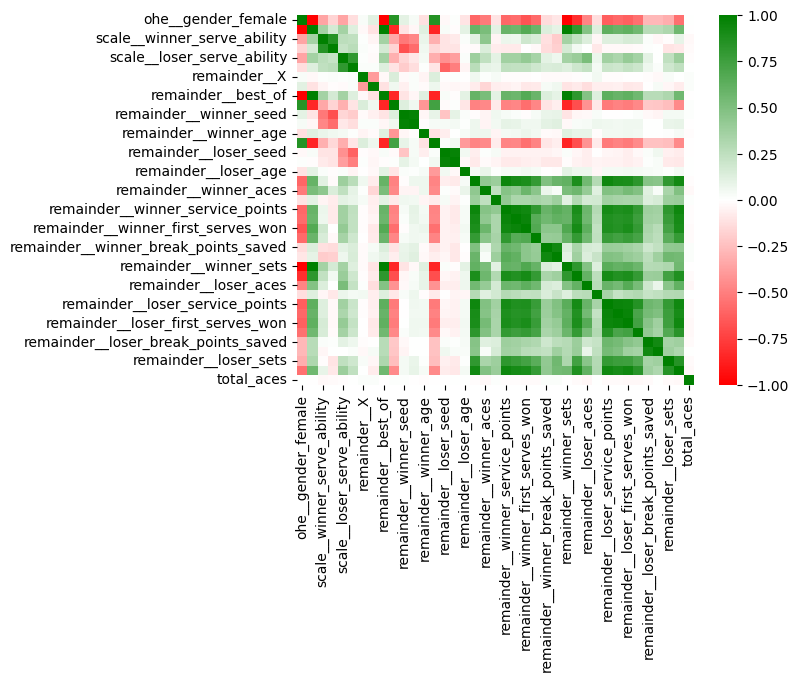

In [119]:
# All numerical features, excluding names, dates and "surface".
raw_aces_data = df.loc[:, ['X', 'match_num', 'best_of', 'gender', 'winner_id', 'winner_seed', 'winner_rank', 'winner_age', 'winner_rating_score', 'winner_serve_ability', 'loser_id', 'loser_seed', 'loser_rank', 'loser_age', 'loser_rating_score', 'loser_serve_ability', 'minutes', 'winner_aces', 'winner_double_faults', 'winner_service_points', 'winner_first_serves_in', 'winner_first_serves_won', 'winner_second_serves_won', 'winner_break_points_saved', 'winner_break_points_faced', 'winner_sets', 'winner_games', 'loser_aces', 'loser_double_faults', 'loser_service_points', 'loser_first_serves_in', 'loser_first_serves_won', 'loser_second_serves_won', 'loser_break_points_saved', 'loser_break_points_faced', 'loser_sets', 'loser_games']]

X = raw_aces_data.copy()
X["total_aces"] = df["winner_aces"] + df["loser_aces"]

y = X.pop("total_aces")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

# Future-proofing: making a column transformer

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(), ["gender"]),
        ("scale", StandardScaler(), ["winner_serve_ability", "winner_rating_score", "loser_serve_ability", "loser_rating_score"])
    ],
    remainder = "passthrough"
)

column_transformer.fit(raw_aces_data)

raw_aces_transformed = column_transformer.transform(raw_aces_data)
raw_aces_transformed = pd.DataFrame(raw_aces_transformed, columns = column_transformer.get_feature_names_out())

Xt_train = pd.DataFrame(column_transformer.transform(X_train), columns = column_transformer.get_feature_names_out())
Xt_test = pd.DataFrame(column_transformer.transform(X_test), columns=column_transformer.get_feature_names_out())

Xt_train_with_aces = Xt_train.copy()
Xt_train_with_aces["total_aces"] = y_train

display(Xt_train_with_aces.corr())

sns.heatmap(data = Xt_train_with_aces.corr(), cmap = LinearSegmentedColormap.from_list("rg",["r", "w", "g"], N=256))

plt.show()

I do not think this is going to work. However, we will see what happens if we try a few models. Let's remove the multicolinearity and then fit-predict. We will consider `minutes` as a decent representation of all of the green square variables in the bottom right of the heatmap. We will also remove one of the ohe gender columns. For the purpose of the model, we will remove rows containing at least one NaN in one of the columns. Yes, this introduces some bias but I think declaring that we will not be able to predict the number of aces in a match if there is the serving ability is not specified is reasonable - this is the main source of NaNs.

,ohe__gender_male,scale__winner_serve_ability,scale__winner_rating_score,scale__loser_serve_ability,scale__loser_rating_score,remainder__winner_rank,remainder__winner_age,remainder__loser_rank,remainder__loser_age,remainder__minutes,total_aces
ohe__gender_male,1.000000,0.354122,0.163036,0.361653,0.124877,-0.034899,0.130615,-0.020916,0.105471,0.615318,0.007750
scale__winner_serve_ability,0.354122,1.000000,0.848853,0.261879,0.250681,-0.445015,0.114253,-0.090262,0.041858,0.104686,0.002872
scale__winner_rating_score,0.163036,0.848853,1.000000,0.220592,0.273911,-0.542902,0.089097,-0.107450,0.008725,-0.024190,-0.002240
scale__loser_serve_ability,0.361653,0.261879,0.220592,1.000000,0.797585,-0.095312,0.053274,-0.379956,0.048817,0.378641,0.054210
scale__loser_rating_score,0.124877,0.250681,0.273911,0.797585,1.000000,-0.131226,0.026136,-0.516374,-0.030450,0.269570,0.029740
remainder__winner_rank,-0.034899,-0.445015,-0.542902,-0.095312,-0.131226,1.000000,-0.018911,0.053010,-0.000050,0.058270,0.006008
remainder__winner_age,0.130615,0.114253,0.089097,0.053274,0.026136,-0.018911,1.000000,-0.014035,0.039000,0.075797,0.006837
remainder__loser_rank,-0.020916,-0.090262,-0.107450,-0.379956,-0.516374,0.053010,-0.014035,1.000000,0.009898,-0.100124,-0.017018
remainder__loser_age,0.105471,0.041858,0.008725,0.048817,-0.030450,-0.000050,0.039000,0.009898,1.000000,0.057644,-0.002118
remainder__minutes,0.615318,0.104686,-0.024190,0.378641,0.269570,0.058270,0.075797,-0.100124,0.057644,1.000000,0.030865


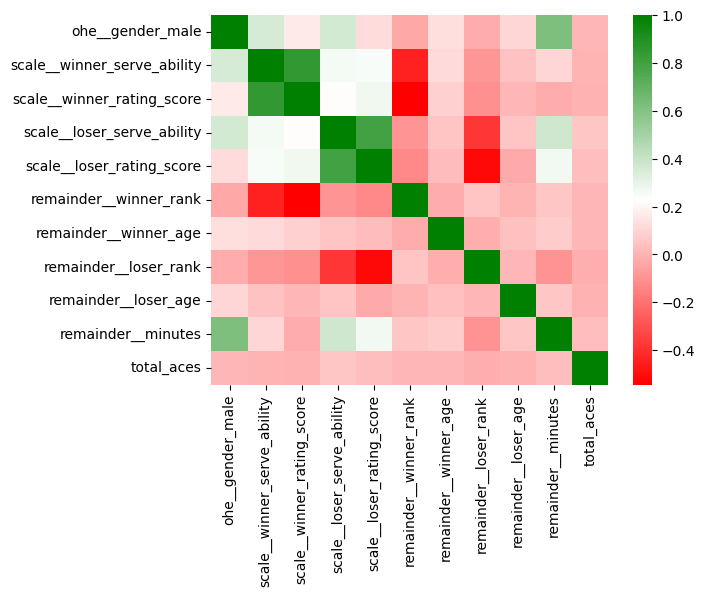

In [120]:
# Key candidate features picked out

raw_aces_data = df.loc[:, [
    "gender",
    "winner_rank",
    "winner_serve_ability",
    "winner_rating_score",
    "winner_age",
    "loser_rank",
    "loser_serve_ability",
    "loser_rating_score",
    "loser_age",
    "minutes",
]]

X = raw_aces_data.copy()
X.dropna(axis = 0, inplace = True) # Drops row with a NaN in any cell
X["total_aces"] = df["winner_aces"] + df["loser_aces"]

y = X.pop("total_aces")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

# Column transformer

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(), ["gender"]),
        ("scale", StandardScaler(), ["winner_serve_ability", "winner_rating_score", "loser_serve_ability", "loser_rating_score"])
    ],
    remainder = "passthrough"
)

column_transformer.fit(raw_aces_data)

raw_aces_transformed = column_transformer.transform(raw_aces_data)
raw_aces_transformed = pd.DataFrame(raw_aces_transformed, columns = column_transformer.get_feature_names_out())

Xt_train = pd.DataFrame(column_transformer.transform(X_train), columns = column_transformer.get_feature_names_out())
Xt_test = pd.DataFrame(column_transformer.transform(X_test), columns=column_transformer.get_feature_names_out())

Xt_train.drop("ohe__gender_female", axis = 1, inplace = True) # Drop female column avoiding multicolinearity
Xt_test.drop("ohe__gender_female", axis = 1, inplace = True)

Xt_train_with_aces = Xt_train.copy()
Xt_train_with_aces["total_aces"] = y_train

display(Xt_train_with_aces.corr())

sns.heatmap(data = Xt_train_with_aces.corr(), cmap = LinearSegmentedColormap.from_list("rg",["r", "w", "g"], N=256))

plt.show()


Removing NaNs changed the heatmap! Perhaps this really will work. All of the features correlate somewhat now. Let's see.

In [121]:
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(Xt_train, y_train)

y_pred = model.predict(Xt_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE is {mse**0.5:.4f}')
print(f'MAE is {mae:.4f}')
print(f'R-squared is {r2:.4f}')

RMSE is 8.9659
MAE is 6.2878
R-squared is 0.2196


In [122]:
linearregression = LinearRegression()
linearregression.fit(Xt_train, y_train)

y_pred = linearregression.predict(Xt_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE is {mse**0.5:.4f}')
print(f'MAE is {mae:.4f}')
print(f'R-squared is {r2:.4f}')

RMSE is 6.3345
MAE is 4.5376
R-squared is 0.6104


In [123]:
decisiontree = DecisionTreeRegressor()
decisiontree.fit(Xt_train, y_train)

y_pred = decisiontree.predict(Xt_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE is {mse**0.5:.4f}')
print(f'MAE is {mae:.4f}')
print(f'R-squared is {r2:.4f}')

RMSE is 9.5271
MAE is 6.4463
R-squared is 0.1188


There are a few other things we could do here including k-fold cross-validation in order to optimise the values of the hyperparameters for each model.

However, we have already quite a good model in the form of the linear regression model that has R-squared 0.61. Let's stick with that for now.

A thoroughly enjoyable task. Thank you very much for reading all the way through.

Jia Jie